In [1]:
import keras
from keras.applications import VGG19
import pandas as pd
import os

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(200, 200, 3))

Building the folder hierarchy to maintain the image labels happens via a different program. The source can be found [here](https://github.com/eamander/Cat_Type_ID_Project/tree/master/label_maker). In this case, we'll construct symbolic links to the files since there are so many of them and labeling will proceed much more quickly.

In [3]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(51, activation='sigmoid'))

In [4]:
conv_base.trainable = False

Now we run in to a problem. ImageDataGenerators are not designed to handle k-hot encoded images for multilabel image classifiation. We will need to modify our ImageDataGenerator so that its flow_from_directory method can reference an external dictionary containing our labels. We will also need to build the dictionary we want to use and assign it to our ImageDataGenerator. We will be using file paths as a reference so that the same dictionary can be used for all train, test, and validation generators, which means we'll only have to modify the base class, not each of its instances.

In [5]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.backend import floatx

def k_hot_dict_maker(dframe, data_col=None, label_cols=None):
    if data_col is None:
        data_col = 'file_name'
        if 'file_name' in dframe.columns:
            pass
        else:
            # This lets us use the same formulation for the rest of the function
            dframe.index.rename(data_col, inplace=True)
            dframe.reset_index(inplace=True)

    if label_cols is None:
        label_cols = dframe.columns.sort_values().tolist()
        label_cols.remove(data_col)
        label_cols.sort()

    # push the file_names, which are unique, into the index

    dframe = dframe.set_index(data_col)

    # store a list-like object containing all unique labels for each category
    labels_arr = np.empty((0,))
    for col in label_cols:
        labels_arr = np.append(labels_arr, dframe[col].unique())

    labels_arr = pd.Series(labels_arr).unique()
    labels_arr.sort()

    label_count = len(labels_arr)

    label_dict = {}
    for fpath in dframe.index:
        vect = np.zeros((label_count,), dtype=floatx())
        label_list = dframe.loc[fpath].tolist()
        vect[labels_arr.searchsorted(label_list)] += 1

        label_dict[fpath] = vect

    return label_dict


# This has to happen in a couple of steps. Each call of flow_from_directory creates a new DirectoryIterator.
# If we want each new DirectoryIterator to have a new _get_batches_of_transformed_samples method
# (disregarding the fact that it is a protected method; this is the only method where we can insert this functionality),
# we need to modify the DirectoryIterator as it leaves the function:
def multilabel_decorator(func, label_dict):

    # Catch the DirectoryIterator returned by func:
    def inner1(*args, **kwargs):
        dir_iter = func(*args, **kwargs)
        
        old_batch_getter = dir_iter._get_batches_of_transformed_samples
        # Modify dir_iter's method using our label_dict
        def inner(index_array):
            func_return = old_batch_getter(index_array)
            # Build the return array by collecting all of the k-hot encoded vectors from the dict
            if isinstance(func_return, tuple):
                batch_x = func_return[0]
            else:
                batch_x = func_return
            batch_y = np.zeros((len(batch_x), dir_iter.num_classes), dtype=floatx())
            for i, j in enumerate(index_array):
                batch_y[i] = label_dict[dir_iter.filenames[j]]

            return batch_x, batch_y

        dir_iter._get_batches_of_transformed_samples = inner

        # Return dir_iter, just as before
        return dir_iter

    return inner1

One of the quirks of this patch to the DirectoryIterator functionality is that the samples still have to reside in one of the class folders. What's more, the file names contained in dir_iter.filenames[] contain just the latter portion of the file name, so our dictionary must contain something like "None\\cat_456.jpg" rather than the original path directory. We must replace None with a label from the dataset or else keras won't find the images.

A more robust solution to this problem might be to extend the base method DirectoryIterator._get_batches_of_transformed_samples_ to operate on a new kind of hierarchy that would define a k-hot encoding of some sort, or (as in [this solution](https://github.com/tholor/keras/blob/29ceafca3c4792cb480829c5768510e4bdb489c5/keras/preprocessing/image.py), which is unfortunately somewhat outdated) add the option to pass an array defining the k-hot encoding to ImageGenerator.flow_from_directory().

In [6]:
# Create our label_dictionary:
cat_labels = pd.read_pickle(r"C:\Eamon\Python Studies\Cat Type ID Project\data_entry_app\cat_labels_trial1.df")
label_dict = k_hot_dict_maker(cat_labels)

ImageDataGenerator.flow_from_directory = multilabel_decorator(ImageDataGenerator.flow_from_directory, label_dict)

# We need the sorted list of labels from the DataFrame:

labels_arr = np.empty((0,))
for col in cat_labels.columns[1:]:
    labels_arr = np.append(labels_arr, cat_labels[col].unique())

labels_arr = pd.Series(labels_arr).unique()
labels_arr.sort()

In [7]:

train_datagen = ImageDataGenerator(    
    rescale=1./255,
    rotation_range=40.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=11.,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(
    rescale =1./255)

def build_model(train_path, val_path, model):
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(200, 200),
        batch_size=20,
        # we have multiple labels for each image
        class_mode='categorical',
        classes=labels_arr.tolist(),
        interpolation='bilinear')

    validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=(200, 200),
        batch_size=20,
        class_mode='categorical',
        classes=labels_arr.tolist(),
        interpolation='bilinear')
    
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
    
    return train_generator, validation_generator

Once I have the data directories constructed, build the model using the directories.

The data currently being analyzed are accessed and sorted via a pandas DataDrame. The cleaned DataFrame has bad entries (multiple cats of different descriptions, images of things other than cats, etc.) removed.

In [8]:
cat_labels.groupby('breed').breed.count()

breed
breed_Abyssinian              380
breed_Balinese                  7
breed_Bengal                  179
breed_British Longhair         18
breed_British Shorthair       327
breed_Domestic Longhair        65
breed_Domestic Medium Hair    126
breed_Domestic Shorthair      830
breed_Exotic Shorthair          4
breed_Maine Coon                7
breed_Oriental Shorthair        4
breed_Persian                  10
breed_Siamese                 195
breed_Sphinx                    1
Name: breed, dtype: int64

This smaller dataset does not have a diverse set of images

In [9]:
# train_generator.filenames
label_dict['color_modifier_None\\cat_854.jpg']

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [10]:
train_dir = r"C:\Eamon\Python Studies\data\cat_image_data_labels\train"
validation_dir = r"C:\Eamon\Python Studies\data\cat_image_data_labels\validation"

train_generator, validation_generator = build_model(train_dir, validation_dir, model)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50
      )

Found 1264 images belonging to 51 classes.
Found 349 images belonging to 51 classes.
Epoch 1/30
100/100 [==============================] - 132s 1s/step - loss: 0.3115 - acc: 0.8930 - val_loss: 0.2366 - val_acc: 0.9175
Epoch 2/30
100/100 [==============================] - 132s 1s/step - loss: 0.2306 - acc: 0.9190 - val_loss: 0.2221 - val_acc: 0.9198
Epoch 3/30
100/100 [==============================] - 128s 1s/step - loss: 0.2233 - acc: 0.9194 - val_loss: 0.2155 - val_acc: 0.9222
Epoch 4/30
100/100 [==============================] - 131s 1s/step - loss: 0.2149 - acc: 0.9210 - val_loss: 0.2087 - val_acc: 0.9235
Epoch 5/30
100/100 [==============================] - 144s 1s/step - loss: 0.2125 - acc: 0.9221 - val_loss: 0.2033 - val_acc: 0.9238
Epoch 6/30
100/100 [==============================] - 159s 2s/step - loss: 0.2092 - acc: 0.9227 - val_loss: 0.2022 - val_acc: 0.9267
Epoch 7/30
100/100 [==============================] - 132s 1s/step - loss: 0.2058 - acc: 0.9241 - val_loss: 0.1967 - 

In [11]:
model.save('cat_type_trial1.h5')

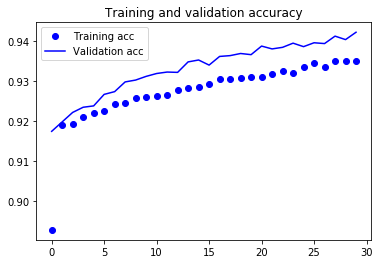

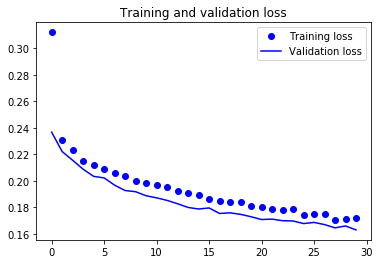

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
test_dir = r"C:\Eamon\Python Studies\data\cat_image_data_labels\test"

test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(200, 200),
        batch_size=20,
        class_mode='categorical',
        classes=labels_arr.tolist(),)

Found 540 images belonging to 51 classes.


In [14]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.9380196106433868


In [20]:
from keras.preprocessing.image import img_to_array, load_img
model = models.load_model(r'cat_type_trial1.h5')

im = load_img(r"C:\Eamon\Python Studies\data\cat_image_data_labels\test\color_modifier_None\cat_579.jpg", 
              target_size = (200, 200))
x = img_to_array(im)/255.
x = x.reshape((1, 200, 200, 3))
x.shape

preds_to_labels = {val: label for (label, val) in validation_generator.class_indices.items()}
labels_to_index = {label: val for (label, val) in validation_generator.class_indices.items()}

C:\Anaconda3\lib\site-packages\keras\models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [21]:
prediction = model.predict(x)

In [22]:
import numpy as np
# pred_indices = np.array([range(38)])[prediction > 0.05]
pred_indices = np.argpartition(prediction, -5).flatten()[-5:]
pred_indices.shape

(5,)

We want one prediction from each category, so find the max in each one. It might be better to train a separate network for each category, but we also know that information is shared between predictions (Siamese cats all have color modifier == point, for instance).

In [34]:
# print(prediction)
# print(pred_indices)

def get_prediction(prediction):
    breed = np.argpartition(prediction[0][:14], -1).flatten()[-1:][0]
    color_modifier = np.argpartition(prediction[0][14:26], -1).flatten()[-1:][0]+14
    primary_color = np.argpartition(prediction[0][26:38], -1).flatten()[-1:][0]+26
    secondary_color = np.argpartition(prediction[0][38:48], -1).flatten()[-1:][0]+38
    tertiary_color = np.argpartition(prediction[0][48:], -1).flatten()[-1:][0]+48
    
    pred_list = [breed, primary_color, secondary_color, tertiary_color, color_modifier]
    
    return [pred_to_label(pred) for pred in pred_list]

def pred_to_label(n):
    return preds_to_labels[n].split('_')[-1]

def trim_labels(lst):
    for i, j in enumerate(lst):
        lst[i] = j.split('_')[-1]

def labels_to_arr(lst):
    ret = []
    ret.append("breed_" + str(lst[0]))
    ret.append("primary_color_" + str(lst[1]))
    ret.append("secondary_color_" + str(lst[2]))
    ret.append("tertiary_color_" + str(lst[3]))
    ret.append("color_modifier_" + str(lst[4]))
    
    indices = []
    for label in ret:
        indices.append(labels_to_index[label])
    
    arr = np.zeros((51,))
    arr[indices] = 1
    
    return arr
    

# lst = get_prediction(prediction)
# trim_labels(lst)
# print(lst)
# print(labels_to_arr(lst))
# print(labels_to_index)

# print("predicted labels: ", [preds_to_labels[pred] for pred in pred_indices])
# print(prediction[0, pred_indices])
# print("actual labels: ", [preds_to_labels[pred] for pred in [14, 20, 16, 3, 21]])
# print(labels_to_arr(prediction[0, [14, 20, 16, 3, 21]]))

['Domestic Shorthair', 'Black', 'None', 'None', 'None']
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0.]
{'breed_Abyssinian': 0, 'breed_Balinese': 1, 'breed_Bengal': 2, 'breed_British Longhair': 3, 'breed_British Shorthair': 4, 'breed_Domestic Longhair': 5, 'breed_Domestic Medium Hair': 6, 'breed_Domestic Shorthair': 7, 'breed_Exotic Shorthair': 8, 'breed_Maine Coon': 9, 'breed_Oriental Shorthair': 10, 'breed_Persian': 11, 'breed_Siamese': 12, 'breed_Sphinx': 13, 'color_modifier_Calico': 14, 'color_modifier_Harlequin': 15, 'color_modifier_Mackerel': 16, 'color_modifier_Marble': 17, 'color_modifier_None': 18, 'color_modifier_Point': 19, 'color_modifier_Spotted': 20, 'color_modifier_Ticked': 21, 'color_modifier_Torbie': 22, 'color_modifier_Tortoiseshell': 23, 'color_modifier_Tuxedo': 24, 'color_modifier_Van': 25, 'primary_color_Black': 26, 'primary_color_Blue': 27, 'primary_color_B

This is actually good for the image in question. We don't always get such easy images. Let's make a random image displayer to test this!

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_random_prediction(folder, dframe, n=9):
    label_dir = os.listdir(folder)[0]
    fnames = [os.path.join(label_dir, name) for name in os.listdir(os.path.join(folder, label_dir))]
    fnames = np.array(fnames)
    np.random.shuffle(fnames)
    
    recall_arr = []
    prec_arr = []
    acc_arr = []
    for name in fnames[:9]:
        im = load_img(os.path.join(folder, name), 
              target_size = (200, 200))
        x = img_to_array(im)/255.
        x = x.reshape((1, 200, 200, 3))
        prediction = model.predict(x)
        pred_labels = get_prediction(prediction)
        true_labels = dframe[dframe.file_name == name].values.tolist()[0][1:]
        trim_labels(true_labels)
        
        truth_arr = labels_to_arr(true_labels)
        pred_arr = labels_to_arr(pred_labels)
        
        tp = (truth_arr * pred_arr).sum()
        fp = ((1-truth_arr) * pred_arr).sum()
        fn = (truth_arr * (1-pred_arr)).sum()
        tn = ((1-truth_arr) * (1-pred_arr)).sum()
        
        prec_arr.append(tp / (tp + fp))
        recall_arr.append(tp / (tp + fn))
        acc_arr.append((tp + tn) / (tp + tn + fp + fn))
        
        
        fig = plt.figure(figsize=(6, 6))
        pred_str = """predictions: breed:{}, primary color:{}, 
                    secondary color: {}, tertiary color: {}, color modifier: {}""".format(*pred_labels)
        true_str = """actual labels: breed:{}, primary color:{}, 
                    secondary color: {}, tertiary color: {}, color modifier: {}""".format(*true_labels)
        ax = fig.add_axes((0,0,1,1))
        ax.set_xlabel(pred_str + "\n" + true_str, fontsize=20)
        ax.imshow(im)
    
    prec_arr = np.array(prec_arr)
    acc_arr = np.array(acc_arr)
    recall_arr = np.array(recall_arr)
    
    return prec_arr, recall_arr, acc_arr
    

In [51]:
cat_labels.groupby('breed')['primary_color', 'secondary_color', 'color_modifier'].describe()

primary_color                                    \
                                   count unique                   top freq   
breed                                                                        
breed_Abyssinian                     380      3     primary_color_Red  249   
breed_Balinese                         7      1   primary_color_Cream    7   
breed_Bengal                         179      4   primary_color_Brown  103   
breed_British Longhair                18      9   primary_color_Cream    6   
breed_British Shorthair              327     11    primary_color_Blue  200   
breed_Domestic Longhair               65      7   primary_color_Black   26   
breed_Domestic Medium Hair           126      9   primary_color_Black   37   
breed_Domestic Shorthair             830     10   primary_color_Brown  251   
breed_Exotic Shorthair                 4      4   primary_color_Black    1   
breed_Maine Coon                       7      5   primary_color_Black    2   
breed_Oriental Shorthair               4      3   primary_color_Black    2   
breed_Persian                         10      4  primary_color_Silver    5   
breed_Siamese                        195      2   primary_color_Cream  189   
breed_Sphinx                           1      1   primary_color_Cream    1   

                           secondary_color                                     \
                                     count unique                    top freq   
breed                                                                           
breed_Abyssinian                       380      5  secondary_color_Black  333   
breed_Balinese                           7      2   secondary_color_Seal    6   
breed_Bengal                           179      2  secondary_color_Black  177   
breed_British Longhair                  18      7   secondary_color_Seal    5   
breed_British Shorthair                327      8   secondary_color_None  229   
breed_Domestic Longhair                 65      6   secondary_color_None   26   
breed_Domestic Medium Hair             126      8  secondary_color_Black   32   
breed_Domestic Shorthair               830      9  secondary_color_Black  234   
breed_Exotic Shorthair                   4      3   secondary_color_None    2   
breed_Maine Coon                         7      4   secondary_color_None    3   
breed_Oriental Shorthair                 4      1   secondary_color_None    4   
breed_Persian                           10      2   secondary_color_None    9   
breed_Siamese                          195      5   secondary_color_Seal  139   
breed_Sphinx                             1      1   secondary_color_Seal    1   

                           color_modifier                                       
                                    count unique                      top freq  
breed                                                                           
breed_Abyssinian                      380      2    color_modifier_Ticked  377  
breed_Balinese                          7      1     color_modifier_Point    7  
breed_Bengal                          179      4   color_modifier_Spotted  174  
breed_British Longhair                 18      7     color_modifier_Point    8  
breed_British Shorthair               327     10      color_modifier_None  230  
breed_Domestic Longhair                65     10  color_modifier_Mackerel   21  
breed_Domestic Medium Hair            126     11  color_modifier_Mackerel   34  
breed_Domestic Shorthair              830     12  color_modifier_Mackerel  273  
breed_Exotic Shorthair                  4      3  color_modifier_Mackerel    2  
breed_Maine Coon                        7      6  color_modifier_Mackerel    2  
breed_Oriental Shorthair                4      1      color_modifier_None    4  
breed_Persian                          10      1      color_modifier_None   10  
breed_Siamese                         195      2     color_modifier_Point  194  
breed_Sphinx              

##Final thoughts on initial experiments (test cases detailed below):

This model could use some fine-tuning (I may not have time to get that done before tomorrow). The clearest problems are that we don't have good coverage of the label-space in the training images (e.g. not much breed coverage, see above), and that some labels imply high baseline accuracy for others (for instance, all Abyssinians are ticked, and most Abyssinians are red).

It might be better to split the task among three networks:
1. Breed
2. Primary, secondary, tertiary color
3. color modifier

By splitting them up, we can decouple information about the colors, for instance, from information about the breed. 

We want to group colors together because the tertiary color category is usually None, so we want some information from the rest of the color labels to bleed over. This should help it identify that if there is a secondary color, there may be a tertiary color.

I intend to try a few different loss metrics too, in order to determine which is best for the task.

Finally, now that most of my tools are in place, it will not be difficult to develop the network into a useful and accurate tool. After that, the next steps will be to move the kernel to a web platform suitable for users.

Let's see how we do on 30 cats!

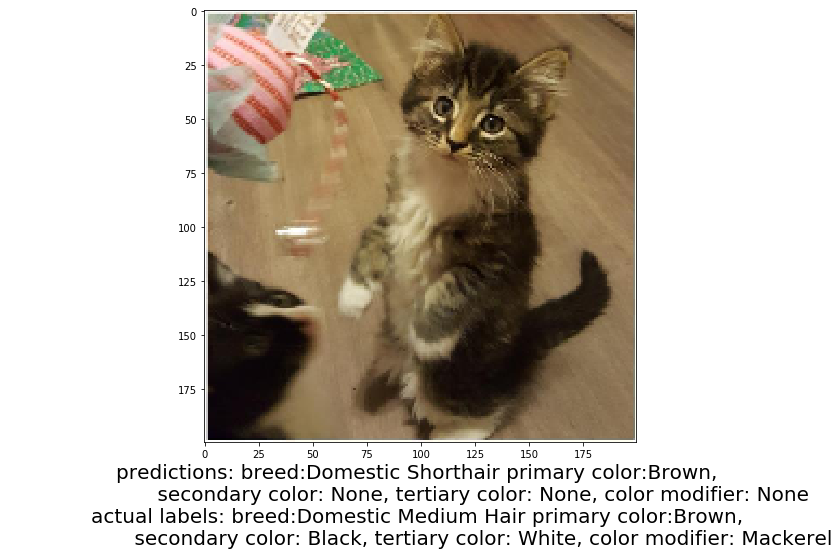

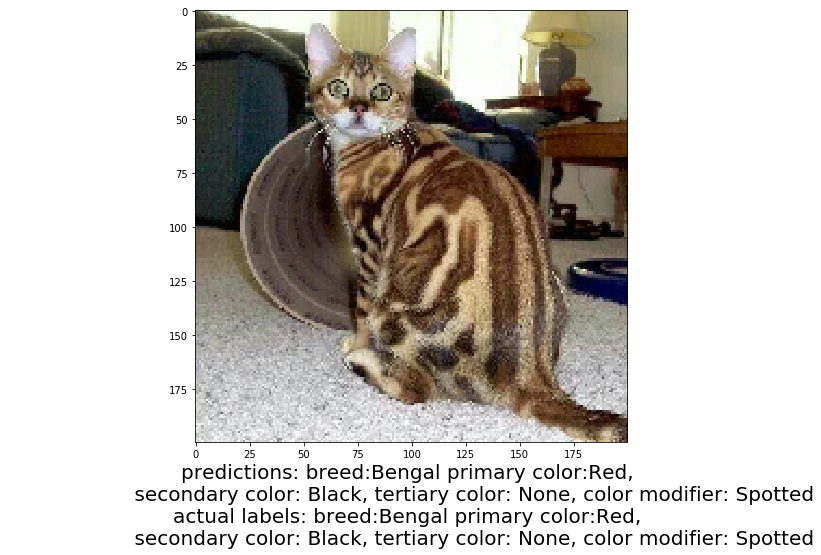

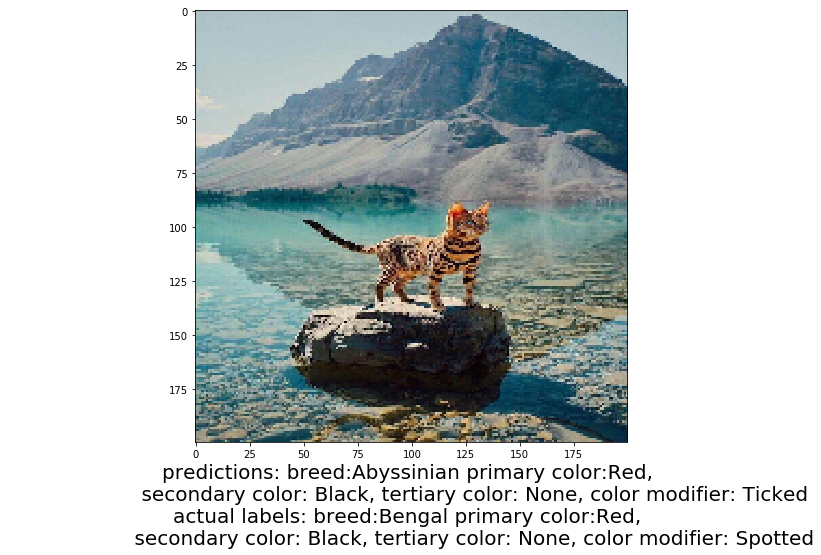

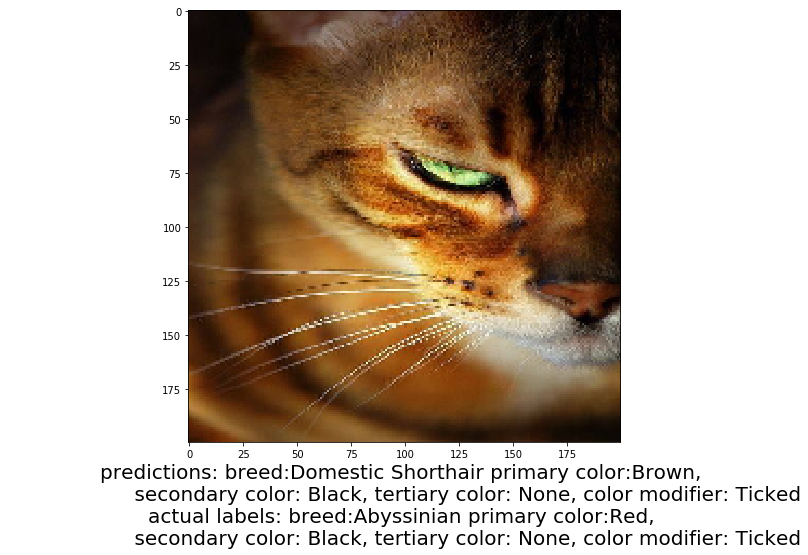

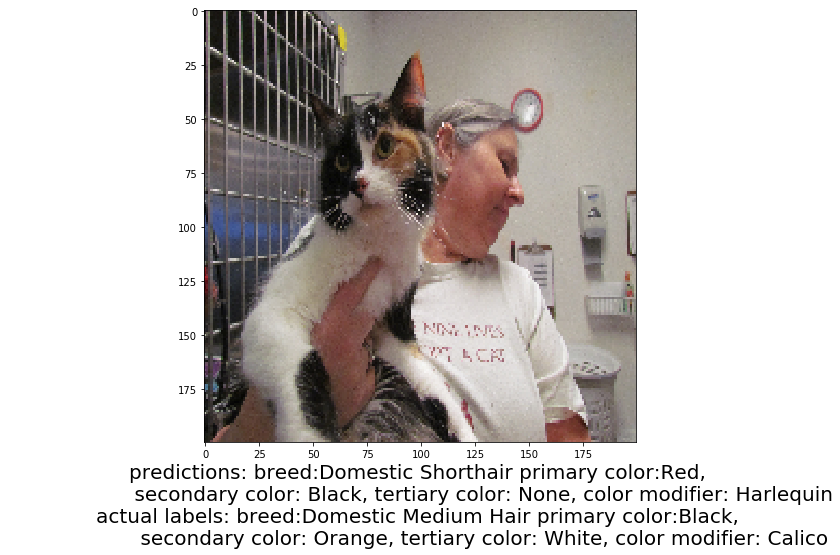

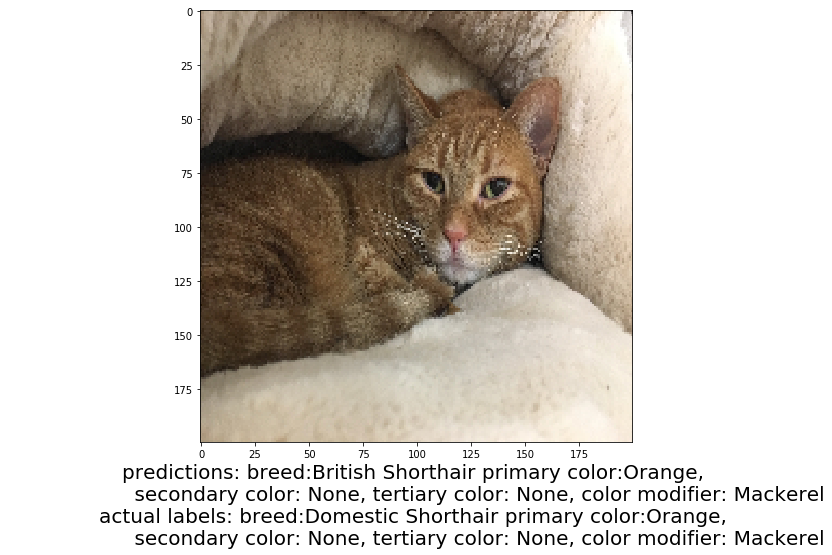

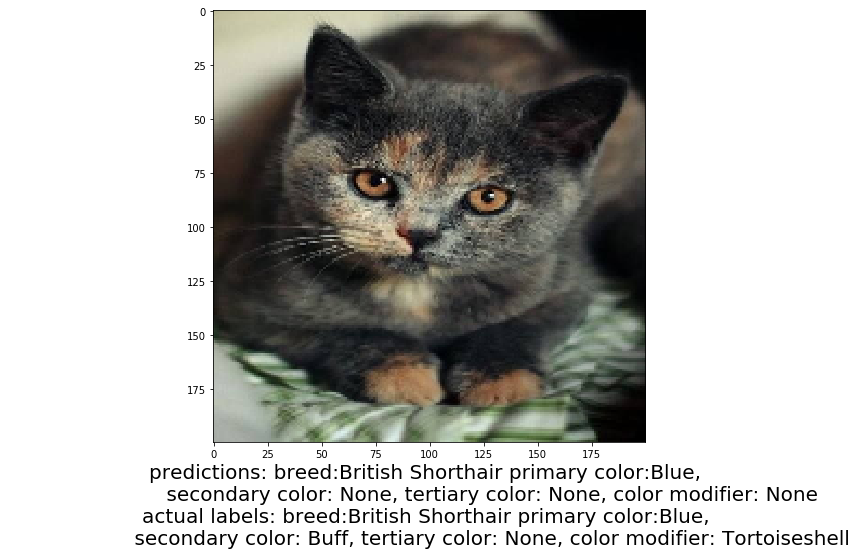

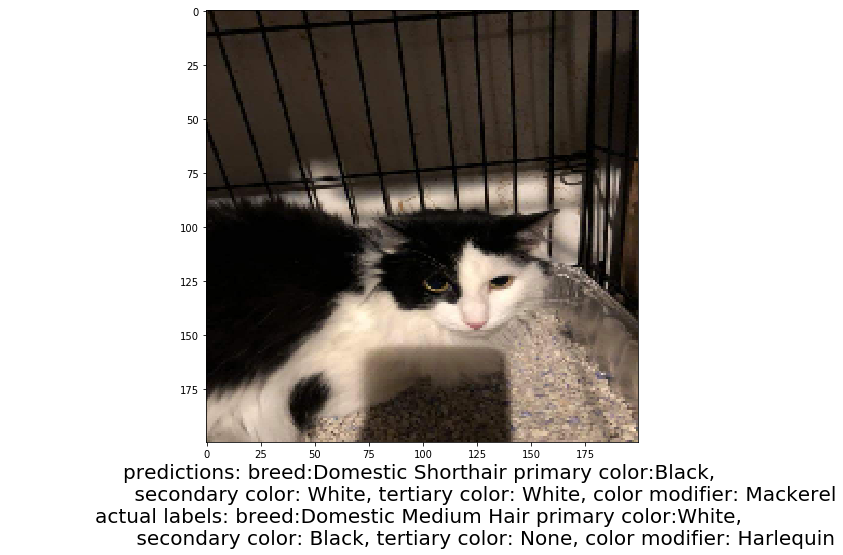

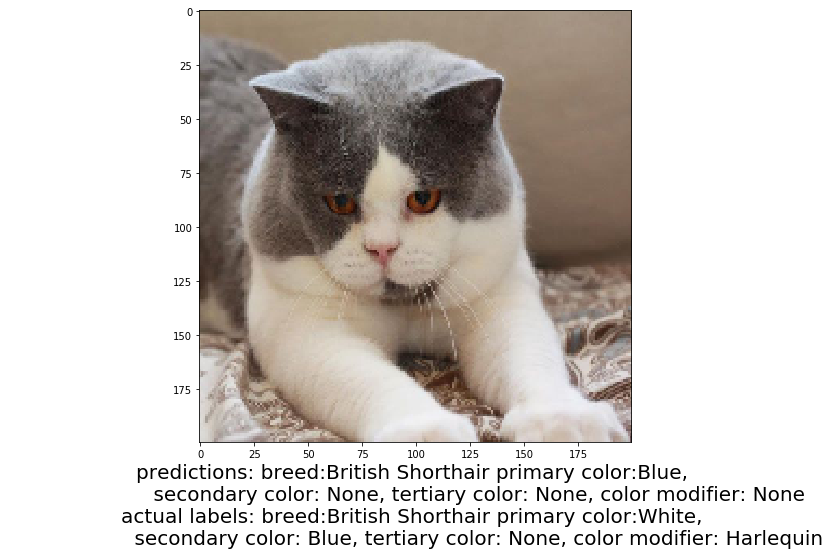

In [43]:
prec, recall, acc = show_random_prediction(r"C:\Eamon\Python Studies\data\cat_image_data_labels\test",
                                           cat_labels, n=30)

In [44]:
print("precision: {}\nrecall: {}\naccuracy: {}".format(prec.mean(), recall.mean(), acc.mean()))

precision: 0.4666666666666667
recall: 0.4666666666666667
accuracy: 0.8954248366013071


So our accuracy is just as we predicted. But we really want to maximize ROC performance, so we will be seeking different techniques and metrics.

Even so, we can see that the algorithm is close! For instance, the last cat was a whte/blue British shorthair. The network found that it was blue, but didn't properly classify that as the secondary color.